In [2]:
import tensorflow as tf
import os
import cv2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Avoid OOM error by setting gpu memory consumption growth
gpus = tf.config.list_physical_devices("GPU")
# os.environ["tf_gpu_allocator"]="cuda_malloc_async"
tf.test.is_gpu_available()
# for gpu in gpus:
#     tf.config.set_memory_growth(gpu, True)

False

In [6]:
# Image checker - checks if we are able to work with the downloaded images

base_dir = "../data/mood_classifier/"
for folder in os.listdir(base_dir):
    for file in os.listdir(os.path.join(base_dir, folder)):
        img_path = os.path.join(base_dir, folder, file)
        try:
            img = cv2.imread(img_path)
            print(".", end="")
        except Exception as e:
            print("Image Error : ", file)
            break
    

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Load and Preprocess the data

In [25]:
tf.keras.utils.image_dataset_from_directory?

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory,
labels='inferred')` will return a `tf.data.Dataset` that yields batches of
images from the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: `.jpeg`, `.jpg`, `.png`, `.bmp`, `.gif`.
Animated gifs are truncated

In [7]:
# This builds data labels based on folders
data = tf.keras.utils.image_dataset_from_directory(base_dir)

Found 729 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()
batch[0].shape
# label 0 -> happy
# label 1 -> Sad

(32, 256, 256, 3)

0


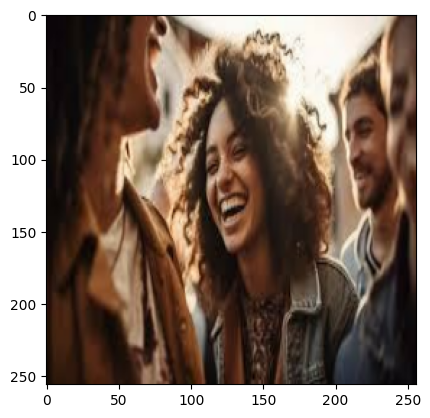

In [10]:
plt.imshow(batch[0][0].astype(int))
print(batch[1][0])

Scale data

In [11]:
batch[0].max()

255.0

In [12]:
data = data.map(lambda x,y: (x//255, y))

In [13]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()
batch[0].max()

1.0

Split Data

In [15]:
# Number of batches , each batch have 32 images
len(data)

23

In [16]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

(16, 5, 2)

In [17]:
train_dataset = data.take(train_size)
val_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size + val_size).take(test_size)

Building the Model

In [19]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

In [20]:
model = tf.keras.models.Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [22]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

Training the Model

In [22]:


logs_dir = "../logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [23]:
hist = model.fit(train_dataset, epochs=3, validation_data=val_dataset)


Epoch 1/3


16/16 [==============================] - 9s 482ms/step - loss: 0.6998 - accuracy: 0.5391 - val_loss: 0.6631 - val_accuracy: 0.6562
Epoch 2/3
16/16 [==============================] - 7s 443ms/step - loss: 0.6206 - accuracy: 0.7188 - val_loss: 0.5982 - val_accuracy: 0.6875
Epoch 3/3
16/16 [==============================] - 7s 431ms/step - loss: 0.5158 - accuracy: 0.7637 - val_loss: 0.5979 - val_accuracy: 0.7000


Plotting the performace

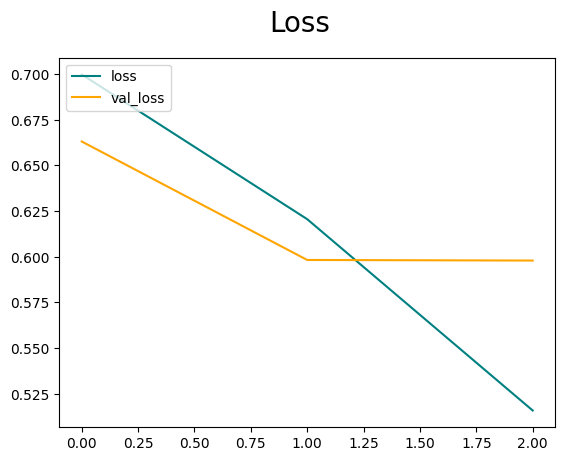

In [24]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

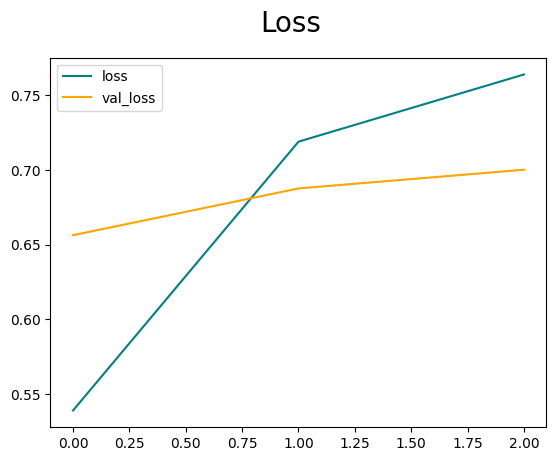

In [25]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="loss")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate the Model

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [28]:
for batch in test_dataset.as_numpy_iterator():
    x, y = batch
    y_predicted = model.predict(x)
    pre.update_state(y, y_predicted)
    rec.update_state(y, y_predicted)
    acc.update_state(y, y_predicted)


1/1 [==============================] - 0s 138ms/step


In [31]:
print(pre.result().numpy())
print(rec.result().numpy())
print(acc.result().numpy())

0.7058824
0.82758623
0.7368421


In [32]:
# use np.expand_dims() when testing for one image

Save the Model

In [33]:
model.save(os.path.join("models", "sentiment_classification.h5"))

c:\Projects\old\poc_testing\ComputerVision\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from tensorflow.keras.models import load_model